### Open University Learning Analytics Dataset Analysis  Using MultiCons

In [1]:
#jupyter notebook --NotebookApp.max_buffer_size=40000000000
## Allocated 4 Gb Memory 

!pip install fuzzy-c-means
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install scikit-learn-extra
!pip install graphviz

Loading all required packages

In [1]:
from os import path

import numpy as np
import pandas as pd
from fcmeans import FCM
from matplotlib import pyplot as plt
from sklearn.cluster import (
    DBSCAN,
    AgglomerativeClustering,
    Birch,
    KMeans,
    SpectralClustering,
)
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids

from multicons import MultiCons
from multicons.utils import jaccard_similarity

np.set_printoptions(threshold=100)
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Loading studentInfo data.

We may get 'average scores' and 'total assessment attempted' from the assessments table; We may get 'number of clicks' and 'number of pages visited' from the VLE table. These engineered data columns are against students, so can be appended to the studentsInfo table.

In [2]:
studentInfo_df = pd.read_csv('studentInfo.csv')
studentInfo_df.info()
studentInfo_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


There are duplicate student ids, probably multiple entries for the same students. Drop these duplicate rows.

In [3]:
cols_to_keep = ['id_student', 'gender', 'region', 
                'highest_education', 'imd_band', 
                'age_band', 'num_of_prev_attempts', 
                'studied_credits', 'disability', 
                'final_result']

# Remove duplicate values
studentProfile_df = studentInfo_df[cols_to_keep].drop_duplicates()
studentProfile_df.info()
studentProfile_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31590 entries, 0 to 32592
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_student            31590 non-null  int64 
 1   gender                31590 non-null  object
 2   region                31590 non-null  object
 3   highest_education     31590 non-null  object
 4   imd_band              30528 non-null  object
 5   age_band              31590 non-null  object
 6   num_of_prev_attempts  31590 non-null  int64 
 7   studied_credits       31590 non-null  int64 
 8   disability            31590 non-null  object
 9   final_result          31590 non-null  object
dtypes: int64(3), object(7)
memory usage: 2.7+ MB


,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


Encode all categorical columns using LabelEncoder. 

In [4]:
from sklearn.preprocessing import LabelEncoder

enc_studentProfile_df = studentProfile_df.copy()

cols_to_encode = ['gender', 'region', 'highest_education', 
                  'imd_band', 'age_band', 'disability', 
                  'final_result']

# Encode categorical data
enc_studentProfile_df[cols_to_encode] = studentProfile_df[cols_to_encode].apply(LabelEncoder().fit_transform)

enc_studentProfile_df.info()
enc_studentProfile_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31590 entries, 0 to 32592
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   id_student            31590 non-null  int64
 1   gender                31590 non-null  int32
 2   region                31590 non-null  int32
 3   highest_education     31590 non-null  int32
 4   imd_band              31590 non-null  int32
 5   age_band              31590 non-null  int32
 6   num_of_prev_attempts  31590 non-null  int64
 7   studied_credits       31590 non-null  int64
 8   disability            31590 non-null  int32
 9   final_result          31590 non-null  int32
dtypes: int32(7), int64(3)
memory usage: 1.8 MB


,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,11391,1,0,1,9,2,0,240,0,2
1,28400,0,6,1,2,1,0,60,0,2
2,30268,0,5,0,3,1,0,60,1,3
3,31604,0,7,0,5,1,0,60,0,2
4,32885,0,11,2,5,0,0,60,0,2


In [5]:
enc_studentProfile_df = enc_studentProfile_df.sample(frac=0.10)
enc_studentProfile_df.shape

(3159, 10)

Plot a correlation matrix for the encoded data frame (all numerical columns).

Considering final result as the dependent variable and the rest as independent variable. We can see some correlation between final result and studied credits. This makes sense.

Among independent variable, there is some correlation between studied credits and number of previous attempts. Again makes sense, as the variables are related.

Remember we need  to ignore student id because it is just a sequence number, it does not represent or relate to dependent variable, final result.

<AxesSubplot:>

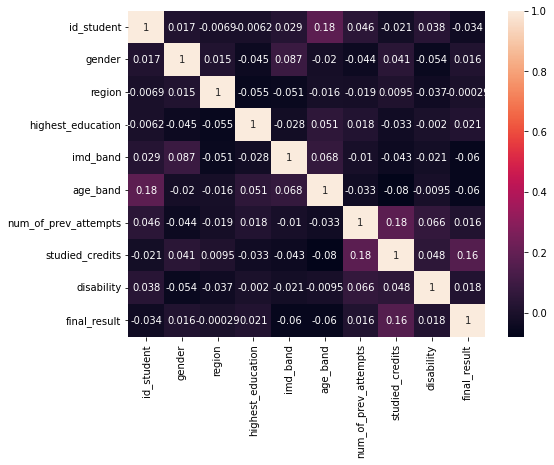

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(enc_studentProfile_df.corr(),annot=True)

Drop the sequence number (student id) and the dependent variable (final result) from the data frame. The latter because we want to determine whether the computed clusters from independent variables has discriminatory power for the dependent variable, for instance, a cluster with failed students.

Clustering often involves distance-based measures, variables with different data ranges may give false sense of effect, in other words, some variables may have more impact on the magnitude of the distance measure.

Standardize all data columns to zero mean.

In [8]:
from sklearn.preprocessing import StandardScaler

cols_to_encode = ['gender', 'region', 'highest_education', 
                  'imd_band', 'age_band', 'num_of_prev_attempts', 
                  'studied_credits', 'disability', 
                  'final_result']

# Standardize the data
scaled_studentProfile_df = StandardScaler().fit_transform(enc_studentProfile_df[cols_to_encode])
scaled_studentProfile_df

array([[ 0.96179296,  1.43123078,  0.99119671, ...,  0.99130194,
        -0.3339778 , -2.00750853],
       [ 0.96179296,  0.32680134, -1.05466439, ..., -0.44068777,
        -0.3339778 ,  0.09832559],
       [-1.0397248 ,  1.15512342,  0.99119671, ..., -0.44068777,
        -0.3339778 ,  0.09832559],
       ...,
       [-1.0397248 , -1.32984283,  0.99119671, ..., -0.44068777,
        -0.3339778 ,  1.15124264],
       [-1.0397248 ,  1.15512342, -1.05466439, ..., -0.44068777,
        -0.3339778 ,  0.09832559],
       [-1.0397248 ,  1.15512342,  0.99119671, ..., -0.44068777,
        -0.3339778 ,  0.09832559]])

Get base clusterings for candidate clustering methods, meaning for every data point get its cluster using different methods. These base clusterings will be used by the consensus algorithm.

I have remarked the time complexities of the differnt algorithms, some are fast while others are slow.

Here I have used the four fastest clustering methods. We can experiment or include the rest.

In [9]:
def get_base_clusterings(df, k):
    # Our collection of base clusterings
    base_clusterings = []

    # K-means O(N.K.L) N: #samples; K: #clusters; L: #iterations
    base_clusterings.append(KMeans(n_clusters=k).fit_predict(df))

    '''
    # Average linkage O(N^3)
    base_clusterings.append(
        AgglomerativeClustering(n_clusters=k).fit_predict(df)
    )
    '''

    # Gaussian model O(N.K.D^3) D: #data dimensions
    base_clusterings.append(
        GaussianMixture(n_components=k, random_state=5).fit_predict(df)
    )


    # C-means O(N.K)
    fcm = FCM(n_clusters=k, max_iter=5, m=5)
    fcm.fit(df)
    base_clusterings.append(fcm.predict(df))

    '''
    # PAM O(N^2)
    base_clusterings.append(KMedoids(n_clusters=k).fit_predict(df))
    '''

    # BIRCH O(N)
    birch = Birch(n_clusters=k, threshold=0.5)
    base_clusterings.append(birch.fit_predict(df))

    '''
    # Spectral O(N^3)
    base_clusterings.append(
        SpectralClustering(n_clusters=k).fit_predict(df)
    )
    '''

    '''
    # DBSCAN O(NlogN)
    base_clusterings.append(DBSCAN(eps=0.2).fit_predict(df))
    '''
    
    return base_clusterings

base_clusterings = get_base_clusterings(scaled_studentProfile_df, 3)

In [10]:
np.array(base_clusterings)

array([[2, 2, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 2],
       [0, 2, 1, ..., 1, 2, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Now that we have the base clusterings, run the consensus algorithm. Why consensus? it is difficult to know what algorithm partitions your data better. So we get base clusterings and find patterns that are shared among them, using frequent itemsets, a data mining approach.

In [11]:
# MultiCons implementation aims to follow scikit-learn conventions.
consensus = MultiCons().fit(base_clusterings)
consensus

MultiCons(consensus_function=<function consensus_function_10 at 0x0000022107E9E4C0>,
          similarity_measure=<function jaccard_similarity at 0x0000022107F2B820>)

The results from the consensus algorithm is a set of clustering vectors, meaning it returns multiple possible solutions. Each row represnts a consensus vector, a solution among the multiple solutions. Moreover, each solution is related hierarchically, each solution from last to first consensus vector (bottom-up fashion) represents the levels of a consensus tree where new base clusters are formed.

In [12]:
# The `consensus_vectors` attribute is a python list containing the
# consensus candidates.
# We transform it to a numpy array to better visualize it here.
np.array(consensus.consensus_vectors)

array([[ 0,  0,  0, ...,  0,  0,  0],
       [32, 33, 34, ..., 34, 29, 31]])

The value of the decision threshold represents the minimum number of base clustering executions (number of base partitions) for building a new base cluster (so-called bi-cluster, or simply the most similar base clusters merged together). 

Here 3 for the first consensus vector is a range of 1 to 3, so basically the smaller threshold is the faster when coming up with consensus. (Need to confirm this)

In [13]:
# The `decision_thresholds` attribute contains a list of decision thresholds
# for each consensus vector.
consensus.decision_thresholds

[3, 4]

The algorithm also recommends a consensus vector (a data partitioning), this is probably related to stability defined below.

In [14]:
# The `recommended` attribute contains the index of the recommended consensus
# vector
consensus.recommended

0

In [15]:
# The `labels_` attribute contains the recommended consensus vector
consensus.labels_

array([0, 0, 0, ..., 0, 0, 0])

Demonstrates the stability of the consensus vector, higher the values the better, the number represent the number of consective decision thresholds to successfully do consensus (bi-clustering - merging of partitions).

In [16]:
# The `stability` attribute contains a list of stability values
# for each consensus vector.
consensus.stability

[3, 1]

Measure related to skewness of the resulting tree. Higher for a symetric tree (so called binary tree).

In [17]:
# The `tree_quality` member contains a measure of the tree quality.
# The measure ranges between 0 and 1. Higher is better.
consensus.tree_quality

0.5

In [18]:
# The `ensemble_similarity` contains a list of ensemble similarity measures
# for each consensus vector.
# They are between 0 and 1. Higher is better.
consensus.ensemble_similarity

array([0.43562012, 0.24618215])

In [25]:
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

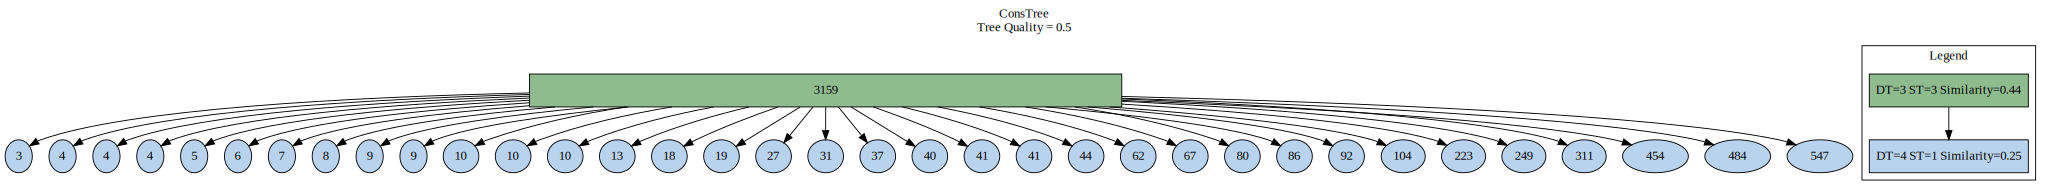

In [26]:
# %% [markdown]
# **Finally, let's visualize the consenus candidates using the ConsTree method:**

# %%
cons_tree = consensus.cons_tree()
cons_tree

In [27]:
# %%
# Save the ConsTree graph to a file
cons_tree.render(outfile=f"./StudentInfoConsTree.svg", cleanup=True)

'StudentInfoConsTree.svg'

In [28]:
studentInfo_df['final_result'].value_counts()

Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: final_result, dtype: int64

Plot a scatter plot for the correlated variables observed in the correlation matrix, 'studied credits' to 'final result'.

In [29]:
enc_studentProfile_df.head()

,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
19427,246060,1,11,2,6,0,0,120,0,0
12095,634552,1,7,0,8,0,0,60,0,2
2998,487681,0,10,2,0,0,0,60,0,2
7599,652851,0,5,2,0,0,0,60,0,2
123,290757,1,5,0,3,0,0,60,0,2


<AxesSubplot:title={'center':'MultiCons Approach'}, xlabel='studied_credits', ylabel='final_result'>

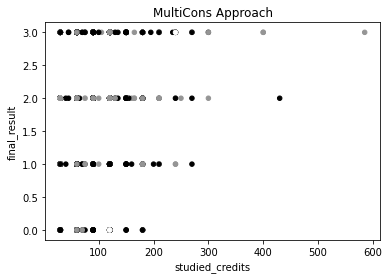

In [30]:
enc_studentProfile_df.plot.scatter(
    title = "MultiCons Approach",
    x = 'studied_credits',
    y = 'final_result',
    c = base_clusterings[0],
)